In [1]:
import sys
import os
sys.path.append('../')

%load_ext autoreload
%autoreload 2
%matplotlib inline

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import cv2
from skimage.io import imread

from gen.load_data import load_data
from gen.generators import preprocess_label
from keras.models import Model, load_model


/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
train_df, valid_df, test_df = load_data('../data')
test_df.head()

image     id                             label
0  ../data/Test/CameraRGB/00019.png  00019  ../data/Test/CameraSeg/00019.png
1  ../data/Test/CameraRGB/00413.png  00413  ../data/Test/CameraSeg/00413.png
2  ../data/Test/CameraRGB/00035.png  00035  ../data/Test/CameraSeg/00035.png
3  ../data/Test/CameraRGB/00264.png  00264  ../data/Test/CameraSeg/00264.png
4  ../data/Test/CameraRGB/00172.png  00172  ../data/Test/CameraSeg/00172.png

In [6]:
from models.unet import model_unetVGG16
from models.segnet import model_segnetVGG16
import keras.backend as K
# model = model_unetVGG16(nClasses=3, image_shape=(320, 416, 3))
# model.load_weights('../saved_models/unet/unet_v4/model.hdf5')
# model = load_model('../saved_models/unet/unet_v4/model_saved.h5')
# model = load_model('../saved_models/segnet/segnet_v2//model_saved.h5')

# model = model_segnetVGG16(3, image_shape=(320, 416, 3))
# model.load_weights('../saved_models/segnet/segnet_v2//model.hdf5')

K.set_learning_phase(0)
model = load_model('../saved_models/segnet/segnet_v3/model_saved.h5')

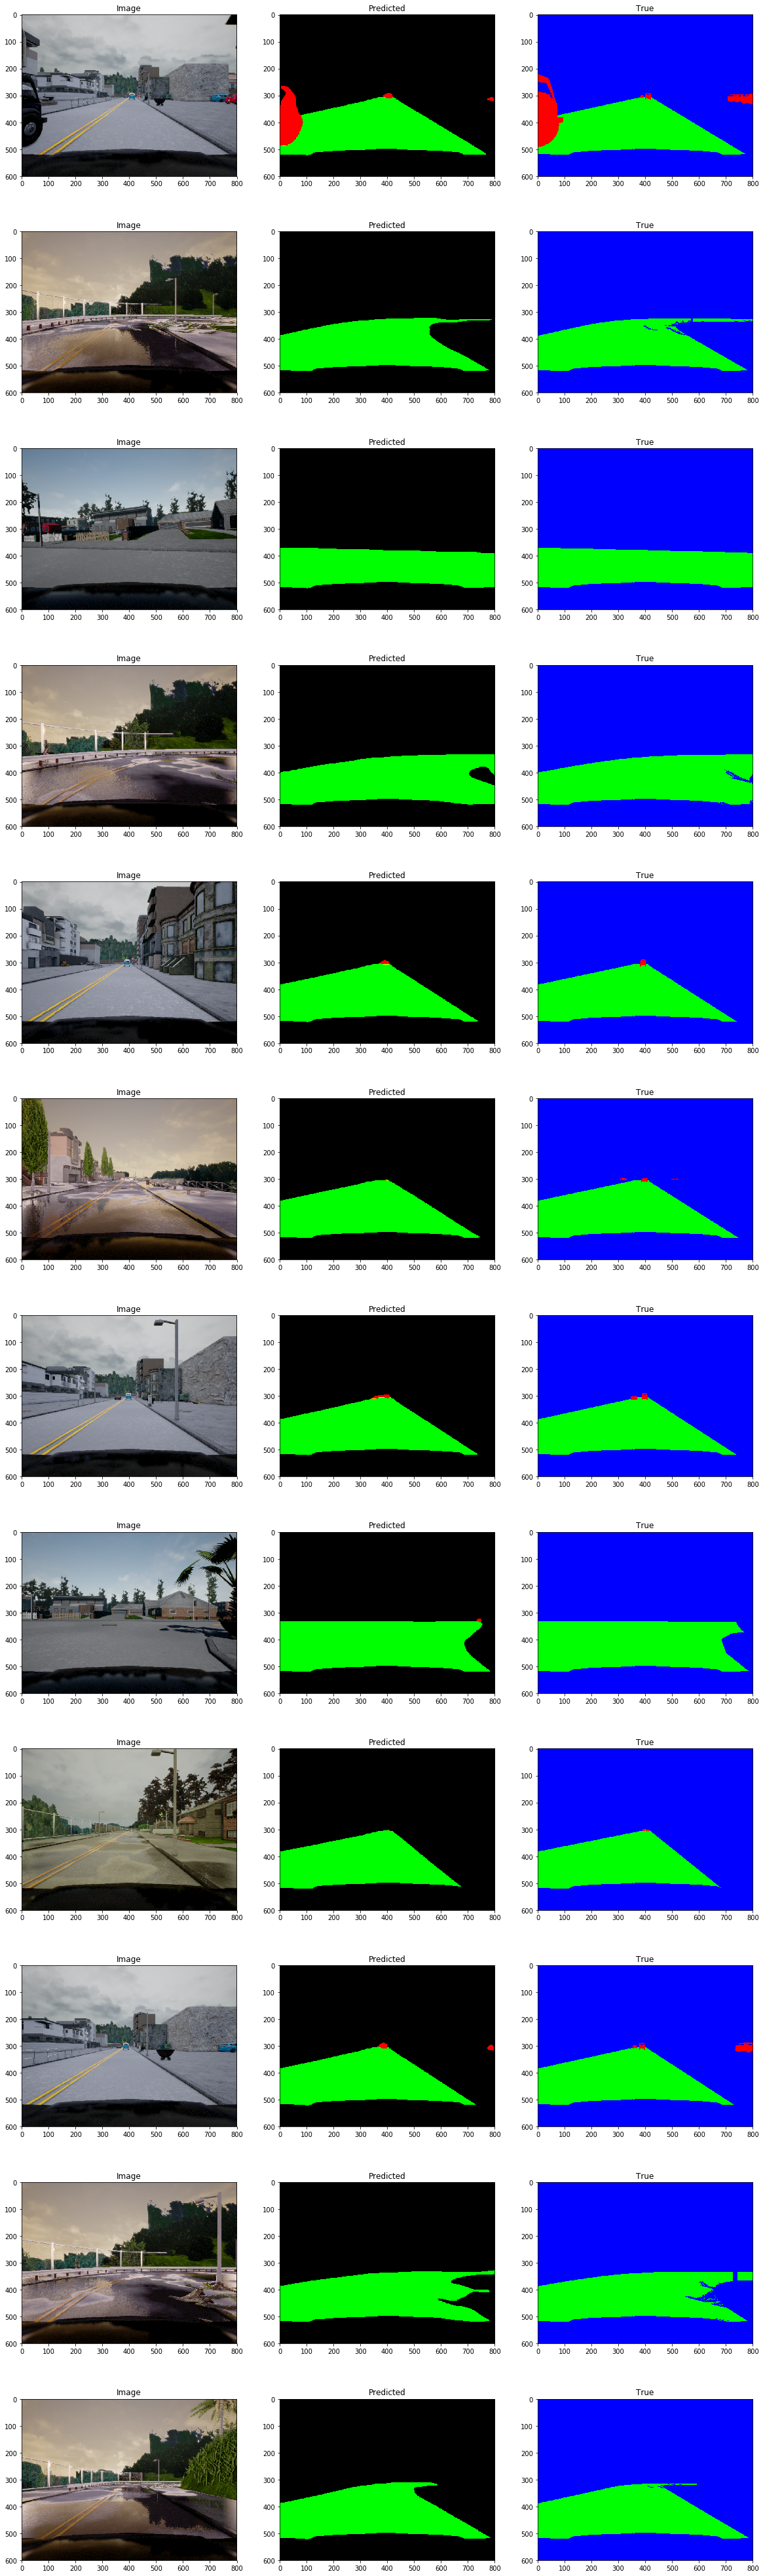

In [7]:
# from keras.applications.vgg16 import preprocess_input

sample_rows = 12
binary_car_result = np.zeros((600, 800))
binary_road_result = np.zeros((600, 800))
fig, m_axs = plt.subplots(sample_rows, 3, figsize = (20, 6*sample_rows))
for (ax1, ax2, ax3), (_, c_row) in zip(m_axs, test_df.sample(sample_rows).iterrows()):
    c_img = imread(c_row['image'])[200:, :, :]
    r_rgb_img = imread(c_row['image'])
    c_img = c_img
    p_img = model.predict(np.expand_dims(cv2.resize(c_img, (416, 320)), 0))[0]
    p_img = p_img.argmax(axis=2)
        
    binary_car_result[200:, :] = cv2.resize((p_img == 0).astype(np.uint8), (800, 400))
    binary_road_result[200:, :] = cv2.resize((p_img == 1).astype(np.uint8), (800, 400))
    
    output_lbl = np.zeros((600, 800, 3))
    output_lbl[:, :, 0] = binary_car_result #cv2.resize(binary_car_result, (800, 600))
    output_lbl[:, : , 1] = binary_road_result #cv2.resize(binary_road_result, (800, 600))
    
    l_img = imread(c_row['label'])
    l_img = preprocess_label(l_img)
    
    ax1.imshow(r_rgb_img)
    ax1.set_title('Image')    
    ax2.imshow(output_lbl)
    ax2.set_title('Predicted')
    ax3.imshow(l_img*255)
    ax3.set_title('True')

In [8]:
def scoreIt(model, image, truth_data_car, truth_data_road):
    result = model.predict(np.expand_dims(image, 0))
    
    output = result[0].argmax(axis=2)
    student_data_car = np.zeros((600, 800))
    student_data_road = np.zeros((600, 800))
    student_data_car[200:, :] = cv2.resize((output == 0).astype(np.uint8), (800, 400))
    student_data_road[200:, :] = cv2.resize((output == 1).astype(np.uint8), (800, 400))
#     student_data_car = cv2.resize((result[0, :, :, 0] > 0.95 ).astype(np.uint8), (800, 600))
#     student_data_road = cv2.resize((result[0, :, :, 1] > 0.7).astype(np.uint8), (800, 600))
        
    Car_TP = 0 # True Positives
    Car_FP = 0 # Flase Positives
    Car_TN = 0 # True Negatives
    Car_FN = 0 # True Negatives

    Road_TP = 0 # True Positives
    Road_FP = 0 # Flase Positives
    Road_TN = 0 # True Negatives
    Road_FN = 0 # True Negatives

    Car_TP += np.sum(np.logical_and(student_data_car == 1, truth_data_car == 1)) + np.e
    Car_FP += np.sum(np.logical_and(student_data_car == 1, truth_data_car == 0)) + np.e
    Car_TN += np.sum(np.logical_and(student_data_car == 0, truth_data_car == 0)) + np.e
    Car_FN += np.sum(np.logical_and(student_data_car == 0, truth_data_car == 1)) + np.e
    
    Road_TP += np.sum(np.logical_and(student_data_road == 1, truth_data_road == 1)) + np.e
    Road_FP += np.sum(np.logical_and(student_data_road == 1, truth_data_road == 0)) + np.e
    Road_TN += np.sum(np.logical_and(student_data_road == 0, truth_data_road == 0))+  np.e
    Road_FN += np.sum(np.logical_and(student_data_road == 0, truth_data_road == 1))+  np.e
    
    Car_precision = Car_TP/(Car_TP+Car_FP)/1.0
    Car_recall = Car_TP/(Car_TP+Car_FN)/1.0
    Car_beta = 2.0
    Car_F = (1+Car_beta**2) * ((Car_precision*Car_recall)/(Car_beta**2.0 * Car_precision + Car_recall))
    Road_precision = Road_TP/(Road_TP+Road_FP)/1.0
    Road_recall = Road_TP/(Road_TP+Road_FN)/1.0
    Road_beta = 0.5
    Road_F = (1+Road_beta**2.0) * ((Road_precision*Road_recall)/(Road_beta**2.0 * Road_precision + Road_recall))
    
    return result, student_data_car, student_data_road,(Car_F + Road_F)/2.0

0.26353077799499336


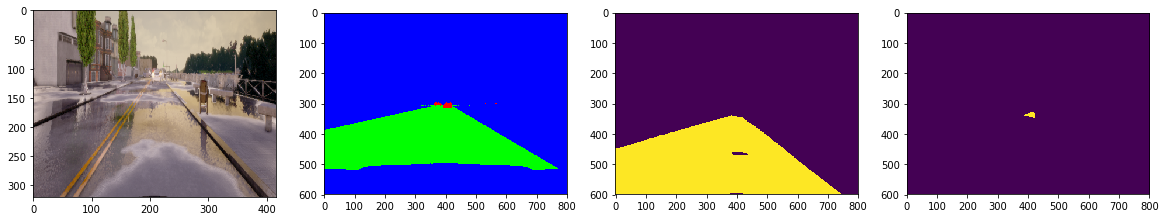

In [10]:
ind = np.random.randint(0, 30)
img = cv2.resize(imread(test_df.loc[ind].image)[200:500, :, :], (416, 320))
lbl = preprocess_label(imread(test_df.loc[ind].label))

res, car, road, score = scoreIt(model, img, lbl[:, :, 0], lbl[:, :, 1])

print (score)
plt.figure(figsize=(20, 20))
plt.subplot(141)
plt.imshow(img)
plt.subplot(142)
plt.imshow(lbl*255)
plt.subplot(143)
plt.imshow(road*255)
plt.subplot(144)
plt.imshow(car*255)

In [17]:
inds = []
scores = []
outputs = []

i = 0
for _, row in test_df.iterrows():
    img = cv2.resize(imread(row.image)[200:, :, :], (416, 320))
    lbl = preprocess_label(imread(row.label))
    res, car, road, score = scoreIt(model, img, lbl[:, :, 0], lbl[:, :, 1])
    scores.append(score)
    inds.append(i)
    outputs.append((res, img, lbl, car, road))
    i += 1

In [18]:
c = sorted(zip(scores, inds))

0.4887223199761731 497
0.4926915573416571 207
0.49574753542205824 459
0.4958403199415444 156
0.49638825104878154 144
0.4965122423903665 87
0.49653205196976224 265
0.496550055112862 431
0.4966474068094023 373
0.4968623740136455 189
0.49701966605464254 367
0.49735763066101585 393
0.49784437802405435 153
0.499030919484095 237
0.49913400016994225 221
0.4995638826627651 338
0.4999310315426858 282
0.4999942108088126 295
0.500189009638193 321
0.5008171105987629 316


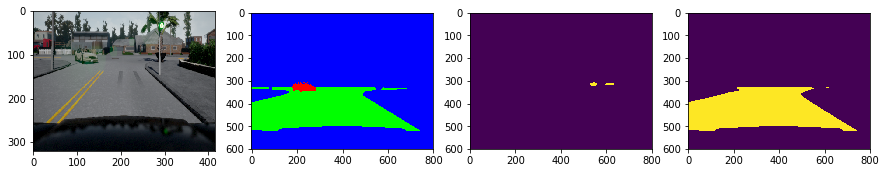

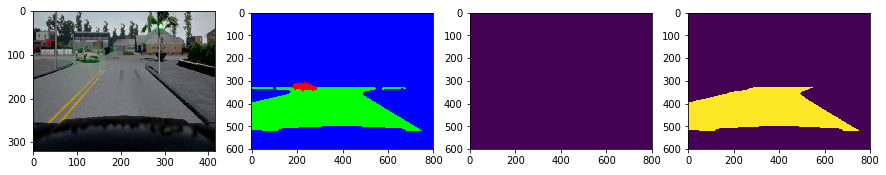

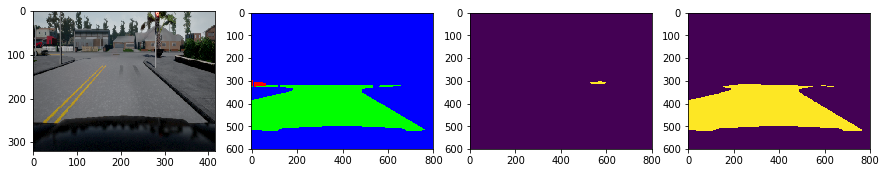

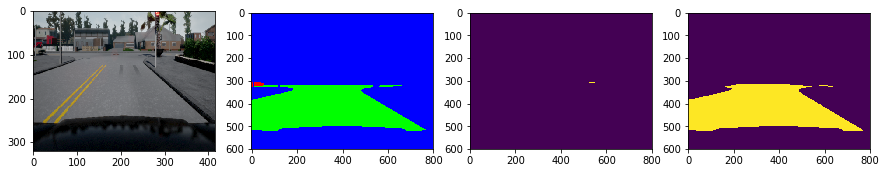

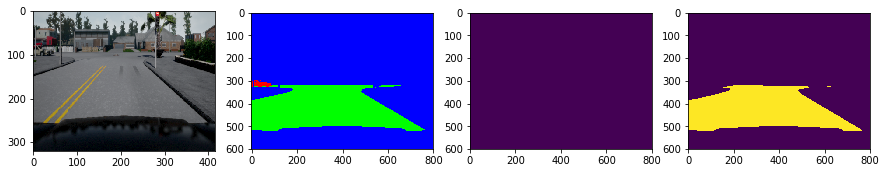

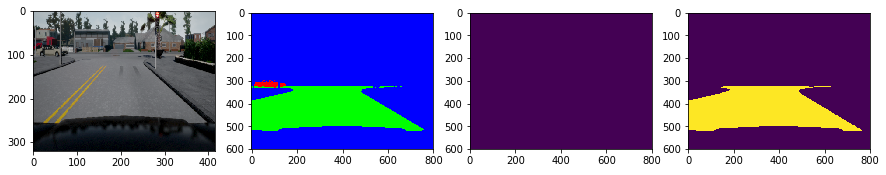

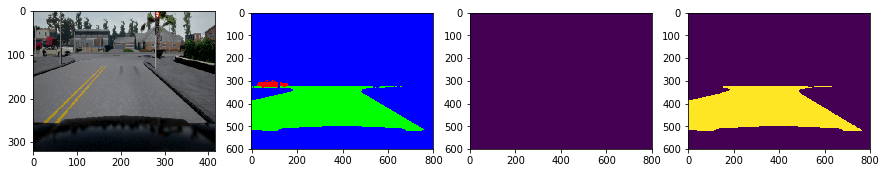

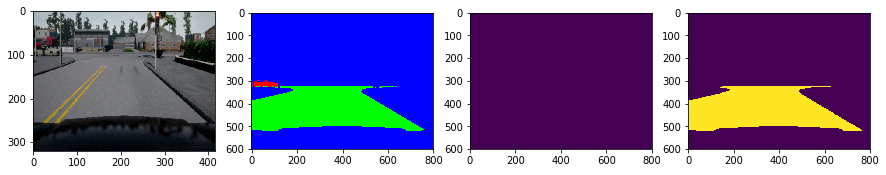

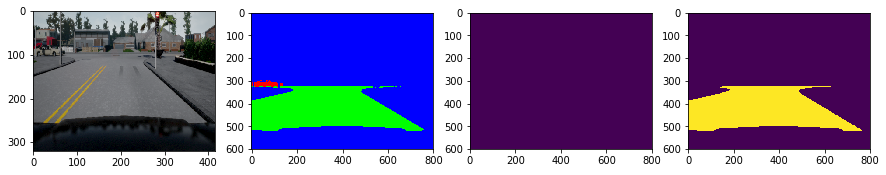

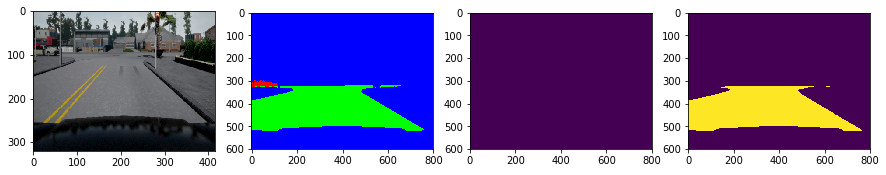

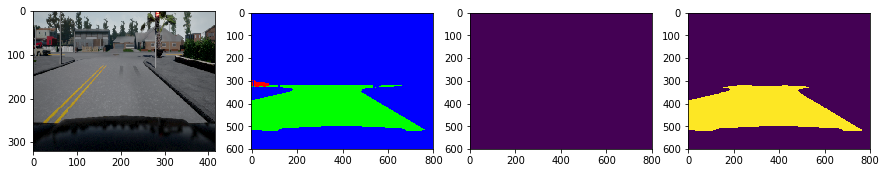

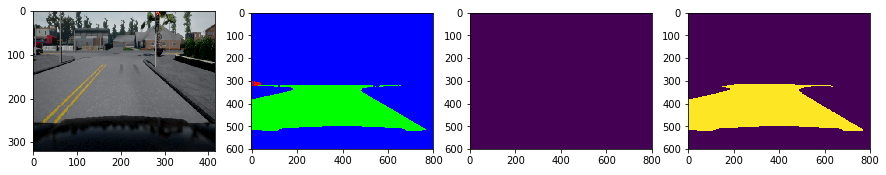

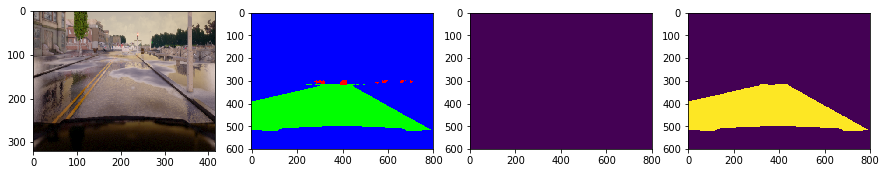

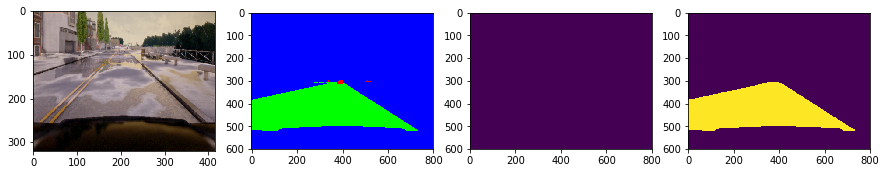

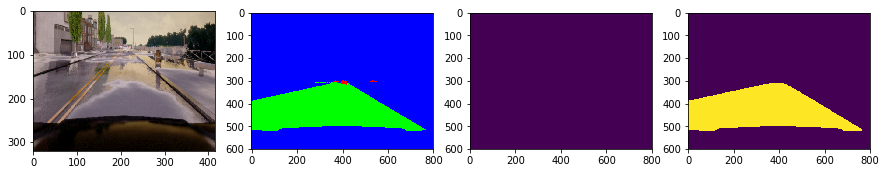

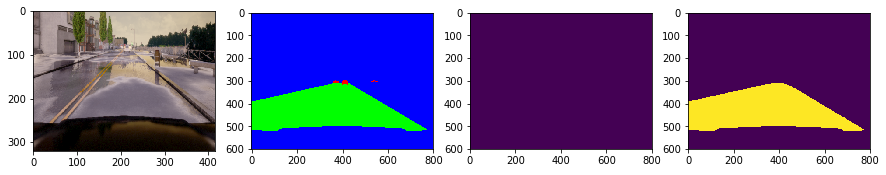

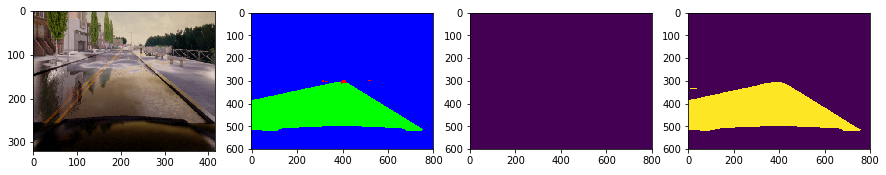

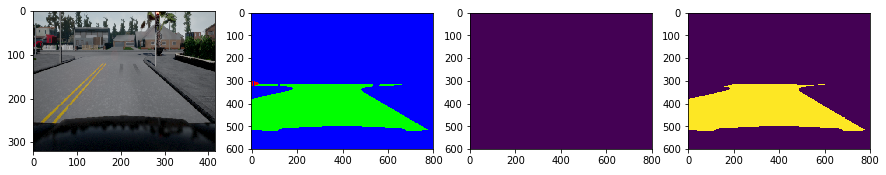

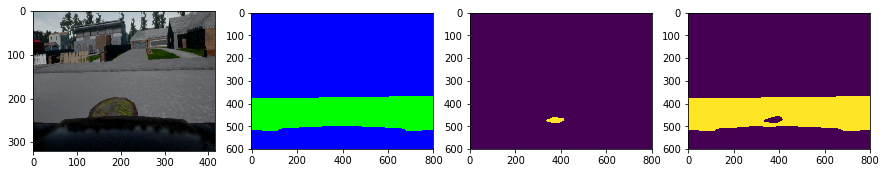

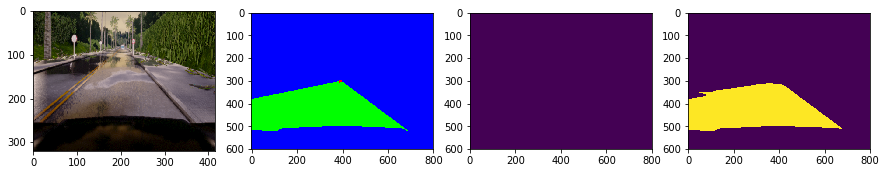

In [21]:
sample = c[0:20]
for s, i in sample:
    print (s, i)
    plt.figure(figsize=(15, 6*len(sample)))
    plt.subplot(141)
    plt.imshow(outputs[i][1])
    plt.subplot(142)
    plt.imshow(outputs[i][2]*255)
    plt.subplot(143)
    plt.imshow(outputs[i][3])
    plt.subplot(144)
    plt.imshow(outputs[i][4])

In [16]:
print (test_df.loc[217].image)

../data/Test/CameraRGB/00048.png


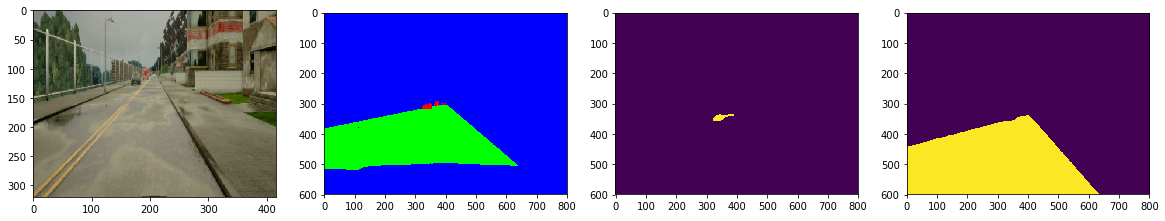

In [14]:
plt.figure(figsize=(20, 20))
plt.subplot(141)
plt.imshow(outputs[217][1])
plt.subplot(142)
plt.imshow(outputs[217][2]*255)
plt.subplot(143)
plt.imshow(outputs[217][3]*255)
plt.subplot(144)
plt.imshow(outputs[217][4]*255)

In [ ]:
probs = outputs[407][0][0]
print (probs[0, 0, 0], probs[0, 0, 1], probs[0, 0, 2])

In [ ]:
plt.imshow(probs[:, :, 0] > 0.9)

In [ ]:
plt.imshow(probs[:, :, 1])